# Optimising the Order of a List of Images for Maximum Visual Dissimilarity Between Adjacent Images

In this notebook we use visual features obtained using a pre-trained deep neural network to determine visual dissimilarity between images. Then we use a genetic algorithm to find an ordering of a list of images that maximises the mean distance between adjacent images. Distance or dissimilarity between images is defined as the cosine distance between the vector representation of an image obtained by pushing the image through a pre-trained neural network.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pylab as plt
import evol
import glob

from scipy.spatial import distance

from plotnine import *
import plotnine.options

In [2]:
%matplotlib inline

In [3]:
plotnine.options.figure_size = (16,9)

## Image Credits

The images are loaded from disk in this notebook, but were originally sourced from Flickr.

Original images are linked here for source and credit:

<a data-flickr-embed="true" data-header="true" data-footer="true" href="https://www.flickr.com/photos/refrodmiel/6186385575/in/photolist-aqEQUg-4GwiUP-7r2PEa-6wTeZJ-c48bfJ-KYk7f-rpQedo-c489Xs-r7oZP5-59J3Bv-B1ac2-7saqN-c489bS-6UHM5K-c488uU-8SKvtB-hYgGa-amdQMe-51sSY-8Xx5tR-659uMw-5eSAzL-68Zw1B-86CPLQ-c4TyDL-8xJGrX-54ZLzg-nLQRiZ-m6KYtE-wFuPQY-fcdyFv-6mheZq-N6xNYm-6UHM3k-SFKJ69-nBSAi-RsSxyN-u8HSjt-pacW5Z-ToBEZ7-6mhewf-amdLKs-KFXwJR-zYM9d-dRUYs2-TCWdZN-UBsoof-4Xw4m3-5tD3KE-dVNFR" title="car"><img src="https://live.staticflickr.com/6151/6186385575_5331a8339f_t.jpg" width="100" height="76" alt="car"></a>

<a data-flickr-embed="true" data-header="true" data-footer="true" href="https://www.flickr.com/photos/stvcr/2427643755/in/photolist-4GwiUP-7r2PEa-6wTeZJ-c48bfJ-KYk7f-rpQedo-c489Xs-r7oZP5-59J3Bv-B1ac2-7saqN-c489bS-6UHM5K-c488uU-8SKvtB-hYgGa-amdQMe-51sSY-8Xx5tR-659uMw-5eSAzL-68Zw1B-86CPLQ-c4TyDL-8xJGrX-54ZLzg-nLQRiZ-m6KYtE-wFuPQY-fcdyFv-6mheZq-N6xNYm-6UHM3k-SFKJ69-nBSAi-RsSxyN-u8HSjt-pacW5Z-ToBEZ7-6mhewf-amdLKs-KFXwJR-zYM9d-dRUYs2-TCWdZN-UBsoof-4Xw4m3-5tD3KE-dVNFR-9CpVnw" title="Car"><img src="https://live.staticflickr.com/3143/2427643755_9677cb5d79_t.jpg" width="100" height="62" alt="Car"></a>

<a data-flickr-embed="true" data-header="true" data-footer="true" href="https://www.flickr.com/photos/naomii/3372221651/in/photolist-68Zw1B-86CPLQ-c4TyDL-8xJGrX-54ZLzg-nLQRiZ-m6KYtE-wFuPQY-fcdyFv-6mheZq-N6xNYm-6UHM3k-SFKJ69-nBSAi-RsSxyN-u8HSjt-pacW5Z-ToBEZ7-6mhewf-amdLKs-KFXwJR-zYM9d-dRUYs2-TCWdZN-UBsoof-4Xw4m3-5tD3KE-dVNFR-9CpVnw-7mFdFH-eRRArC-eREazV-Nn1kru-GSeb4-2f6EwpY-6odGGi-yvDEX-M2Q6B-M2Q2i-XqK6jE-M2Qux-o3Wc1P-i3D7p-PAc3eW-J7Vo6-2njYe-HKYp-M2Qar-ndjEmy-M2Qfn" title="Car"><img src="https://live.staticflickr.com/3257/3372221651_a639c1bf54_t.jpg" width="100" height="66" alt="Car"></a>

<a data-flickr-embed="true" data-header="true" data-footer="true" href="https://www.flickr.com/photos/mathiasappel/25989424636/in/photolist-FAAAud-YhuC49-6ucefd-pPFG4j-bKLVNF-dAsmE-pzme9k-aBRsvw-26JikZb-keFshf-e9J2cP-4FdhzB-28XJnko-bBuiA5-ce8ncY-R9jnDW-9aRtNF-9YpP1Q-rnYKbg-3Pw8eN-bATasW-5ibyg7-ajibvo-H7AH1c-8oiqjq-43DUzo-oKVtHt-eZyMAb-zczBNm-RUuNvS-9YmU7z-9pgKCb-F3uXFa-fR2mPL-4j5WdL-mcCVfy-b5yXo-23y5iVR-9BtV9r-qQ15T1-bnUE4w-dbHKsY-eZnrWK-star-9a1Na-EewBva-SGNezP-pqjQDE-ZroVsh-pGupXv" title="dog"><img src="https://live.staticflickr.com/1643/25989424636_2bb1afe859_t.jpg" width="100" height="66" alt="dog"></a>

<a data-flickr-embed="true" data-header="true" data-footer="true" href="https://www.flickr.com/photos/naparazzi/36942627366/in/photolist-YhuC49-6ucefd-pPFG4j-bKLVNF-dAsmE-pzme9k-aBRsvw-26JikZb-keFshf-e9J2cP-4FdhzB-28XJnko-bBuiA5-ce8ncY-R9jnDW-9aRtNF-9YpP1Q-rnYKbg-3Pw8eN-bATasW-5ibyg7-ajibvo-H7AH1c-8oiqjq-43DUzo-oKVtHt-eZyMAb-zczBNm-RUuNvS-9YmU7z-9pgKCb-F3uXFa-fR2mPL-4j5WdL-mcCVfy-b5yXo-23y5iVR-9BtV9r-qQ15T1-bnUE4w-dbHKsY-eZnrWK-star-9a1Na-EewBva-SGNezP-pqjQDE-ZroVsh-pGupXv-8odpPb" title="DOG"><img src="https://live.staticflickr.com/4381/36942627366_9323f8b526_t.jpg" width="100" height="66" alt="DOG"></a>

<a data-flickr-embed="true" data-header="true" data-footer="true" href="https://www.flickr.com/photos/davidlocke/3600836516/in/photolist-6ucefd-pPFG4j-bKLVNF-dAsmE-pzme9k-aBRsvw-26JikZb-keFshf-e9J2cP-4FdhzB-28XJnko-bBuiA5-ce8ncY-R9jnDW-9aRtNF-9YpP1Q-rnYKbg-3Pw8eN-bATasW-5ibyg7-ajibvo-H7AH1c-8oiqjq-43DUzo-oKVtHt-eZyMAb-zczBNm-RUuNvS-9YmU7z-9pgKCb-F3uXFa-fR2mPL-4j5WdL-mcCVfy-b5yXo-23y5iVR-9BtV9r-qQ15T1-bnUE4w-dbHKsY-eZnrWK-star-9a1Na-EewBva-SGNezP-pqjQDE-ZroVsh-pGupXv-8odpPb-pmn3rq" title="dog"><img src="https://live.staticflickr.com/3373/3600836516_ab924c6729_t.jpg" width="100" height="66" alt="dog"></a>

<a data-flickr-embed="true" data-header="true" data-footer="true" href="https://www.flickr.com/photos/atoach/12239547795/in/photolist-jDyT98-qaw41H-qpFu29-puYgbw-so97LW-qaoRVQ-puYg6S-qrXxer-qaw45F-qaxvkn-qaxw7x-DowPaF-cd9XQj-D2VKCw-MqQ3X1-89f3gN-wM5uzT-8moqyh-2z5TjY-5mCytm-pSnvEM-4VY9Fo-4VY9BL-m8SBj-fR2mNJ-3eQeE-4HnB9n-qaoRLS-BFTEr2-4CQR55-yzFmiU-6g37uX-EFkuC-6TGG7c-dff6Kr-5sBMX5-5o7XD9-XZuuQh-qDmpSj-5AiSZ9-AguCnw-6tpZdv-ammwvP-pJ4aUx-5rX6rZ-4Pr27r-5oGb8f-KHBWW-qaw3SM-cUW8r7" title="Boat"><img src="https://live.staticflickr.com/2874/12239547795_6d8752950c_t.jpg" width="100" height="72" alt="Boat"></a>

<a data-flickr-embed="true" data-header="true" data-footer="true" href="https://www.flickr.com/photos/oatsy40/24307004618/in/photolist-D2VKCw-MqQ3X1-89f3gN-wM5uzT-8moqyh-2z5TjY-5mCytm-pSnvEM-4VY9Fo-4VY9BL-m8SBj-fR2mNJ-3eQeE-4HnB9n-qaoRLS-BFTEr2-4CQR55-yzFmiU-6g37uX-EFkuC-6TGG7c-dff6Kr-5sBMX5-5o7XD9-XZuuQh-qDmpSj-5AiSZ9-AguCnw-6tpZdv-ammwvP-pJ4aUx-5rX6rZ-4Pr27r-5oGb8f-KHBWW-qaw3SM-cUW8r7-UoaR-2ay6bb5-3oMzPm-LUvi5B-5qqd9b-8zzxJV-3pTfRy-RkuPQE-7SgTJA-2rfJV-cDELE-iEbF8D-LvTqZ" title="Boats"><img src="https://live.staticflickr.com/4536/24307004618_f1c3436f4b_t.jpg" width="100" height="75" alt="Boats"></a>

<a data-flickr-embed="true" data-header="true" data-footer="true" href="https://www.flickr.com/photos/_pek_/2858890258/in/photolist-5mCytm-pSnvEM-4VY9Fo-4VY9BL-m8SBj-fR2mNJ-3eQeE-4HnB9n-qaoRLS-BFTEr2-4CQR55-yzFmiU-6g37uX-EFkuC-6TGG7c-dff6Kr-5sBMX5-5o7XD9-XZuuQh-qDmpSj-5AiSZ9-AguCnw-6tpZdv-ammwvP-pJ4aUx-5rX6rZ-4Pr27r-5oGb8f-KHBWW-qaw3SM-cUW8r7-UoaR-2ay6bb5-3oMzPm-LUvi5B-5qqd9b-8zzxJV-3pTfRy-RkuPQE-7SgTJA-2rfJV-cDELE-iEbF8D-LvTqZ-8td4Pn-34QcbL-a9GT2-49PqJr-gQR56-ystCiq" title="Boats"><img src="https://live.staticflickr.com/3171/2858890258_925a8deb64_t.jpg" width="100" height="75" alt="Boats"></a>

<a data-flickr-embed="true" data-header="true" data-footer="true" href="https://www.flickr.com/photos/taniwha/3895090752/in/photolist-6WcmM7-et4FbX-rAHeM3-cXhDWm-bXcZ98-6PNSzZ-9sjery-jbH1EL-kYV5wp-faxUwL-C5rS64-snD97j-27JqSuf-hVrs5x-cmXyfU-rt91YZ-93Dj3L-xKFmaD-dqt4Th-6RDaXe-xYRvSD-bQTnC4-adrBaA-zgYFHB-ziTqeG-4GQRCs-ziTqbW-et69q1-8Enxom-ZTDsLV-ziRWJ5-et7379-a1zyCo-qyHSzz-cZ2mq3-dcCQ5R-21mr1RR-xfdwb8-B81qcD-23ZNCXW-faxU1C-yEfbkU-a1wFdP-arwGTJ-7NtMPK-9gwQqU-j2mNtX-raqX3U-xKFm96-2hD9Bx" title="Driving a van from Blenheim to Wellington"><img src="https://live.staticflickr.com/2596/3895090752_712408a525_t.jpg" width="100" height="66" alt="Driving a van from Blenheim to Wellington"></a>

<script async src="//embedr.flickr.com/assets/client-code.js" charset="utf-8"></script>

In [4]:
image_files = sorted(glob.glob('../flickr-multi/*'))

## Image Feature Vectors

To project images into a feature space, we use an instance of the VGG16 neural network pre-trained on imagenet, with the top layer cut off and avereage pooling applied. This turns arbitrary images into a 512 feature vector.

We load the images twice, once as is for display and once with preprocessing for the network.

In [5]:
pretrained_net = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    pooling='avg',
    input_shape=(224,224,3)
)

In [6]:
# The single letter var is apparently Keras' preferred style
input_layer = tf.keras.layers.Input([None, None, 3], dtype = tf.uint8)
x = tf.cast(input_layer, tf.float32)
x = tf.keras.applications.vgg16.preprocess_input(x)
x = pretrained_net(x)
model = tf.keras.Model(inputs=[input_layer], outputs=[x])

In [7]:
original_images = [
    tf.keras.preprocessing.image.load_img(img_file)
    for img_file in image_files
]

In [8]:
input_images = np.array([
    tf.keras.preprocessing.image.img_to_array(
        tf.keras.preprocessing.image.load_img(img_file, target_size=(224,224))
    )
    for img_file in image_files
])

In [9]:
image_vectors = model(input_images)
image_vectors.shape

TensorShape([10, 512])

## Pairwise Distance Matrix and Visualisation

For visual inspection of our distance metric, we create a pairwise distance matrix in a `DataFrame` and visualise using a tile plot with some annotations.

In [10]:
def show_images(images, rows=2):
    """
    Helper function to display a list of images across multiple rows.
    """
    # The double negation is a silly and hard to mentally parse trick to round up integer divison,
    # but now you know...
    cols = -(-len(images) // rows)

    fig,ax = plt.subplots(
        rows, cols, figsize=(16,9), squeeze=False,
        gridspec_kw=dict(wspace=0, hspace=0))
    for i in range(rows * cols):
        ax[i // cols][i % cols].axis('off')
        if i < len(images):
            ax[i // cols][i % cols].imshow(images[i])
            ax[i // cols][i % cols].text(0, 0, str(i), fontsize=22)

In [11]:
distance_frame = (
    pd.DataFrame(                                           # Construct a DataFrame
        distance.squareform(                                # from the square form
            distance.pdist(image_vectors, distance.cosine)  # of the pairwise cosine distance matrix
                                                            # between images' vector representations
        )
    )
    .reset_index()                                          # Use source image as column
    .rename(columns={'index':'from_image'})
    .assign(from_image=lambda df: df['from_image'].astype('category')) # Turn into categorical
    .melt(id_vars=['from_image'], var_name='to_image', value_name='distance') # Un-pivot for plotting
)

# Add a formatted representation for geom_text()
distance_frame['text_distance'] = distance_frame['distance'].apply(lambda value: '{:.3f}'.format(value))

In [12]:
distance_frame.head()

from_image to_image  distance text_distance
0          0        0  0.000000         0.000
1          1        0  0.522615         0.523
2          2        0  0.352597         0.353
3          3        0  0.782678         0.783
4          4        0  0.785532         0.786

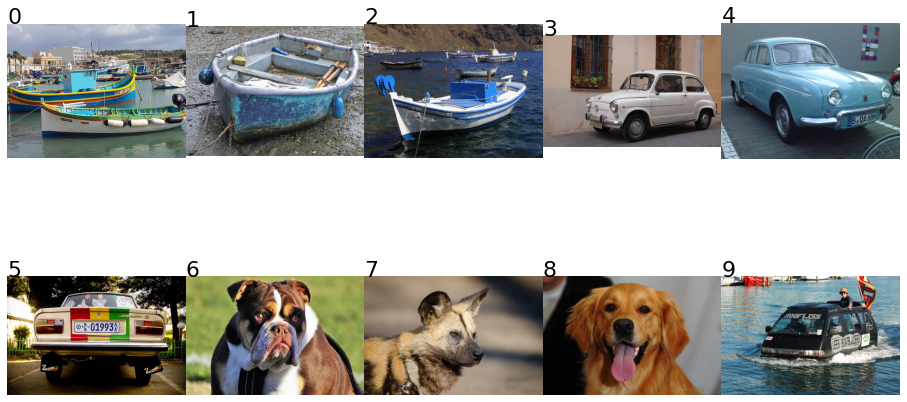

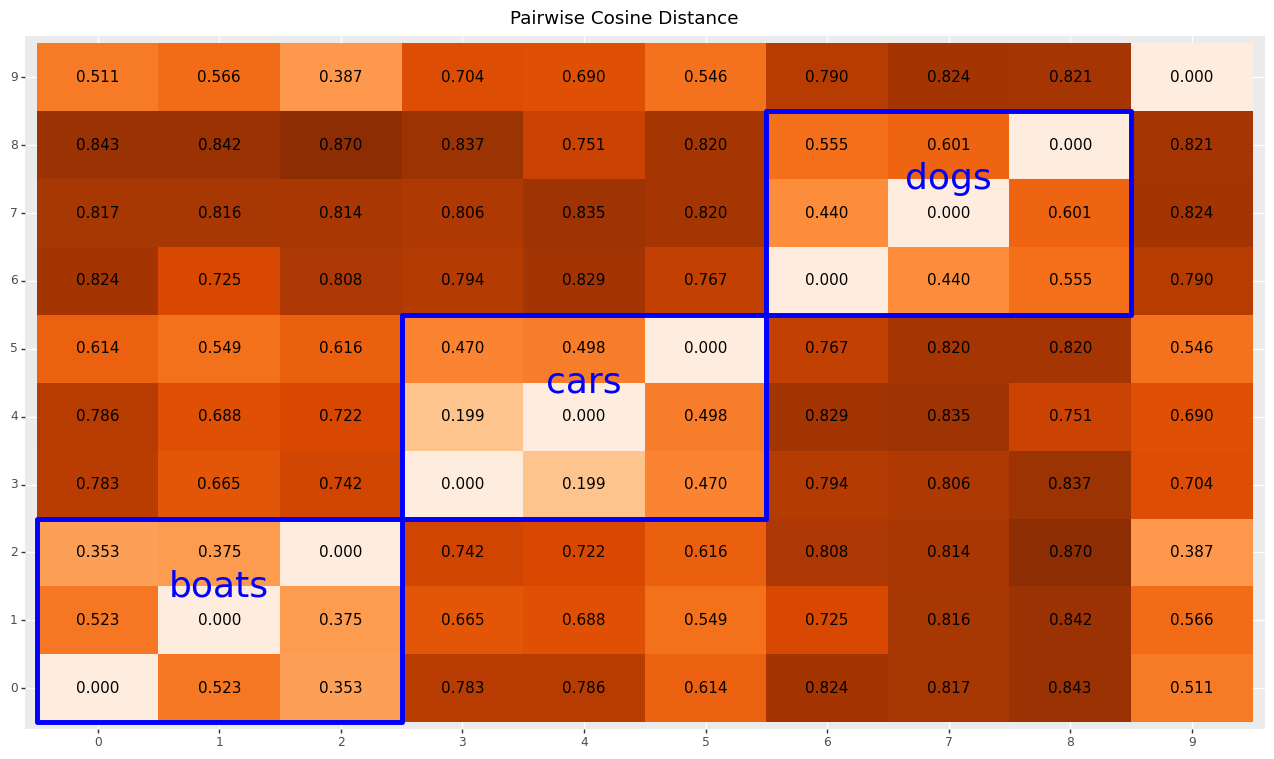

(None, <ggplot: (329203001)>)

In [13]:
# Plot and show images for order
show_images(original_images), (
    ggplot(distance_frame, aes(x='from_image', y='to_image'))
    + geom_tile(aes(fill='distance'))
    + geom_text(aes(label='text_distance'))
    + scale_fill_distiller(palette='Oranges', guide=False)
    
    + annotate(geom='rect', xmin=0.5, ymin=0.5, xmax=3.5, ymax=3.5, fill=None, color='blue', size=2)
    + annotate(geom='text', x=2, y=2.5, label='boats', color='blue', size=26)
    
    + annotate(geom='rect', xmin=3.5, ymin=3.5, xmax=6.5, ymax=6.5, fill=None, color='blue', size=2)
    + annotate(geom='text', x=5, y=5.5, label='cars', color='blue', size=26)
    
    + annotate(geom='rect', xmin=6.5, ymin=6.5, xmax=9.5, ymax=9.5, fill=None, color='blue', size=2)
    + annotate(geom='text', x=8, y=8.5, label='dogs', color='blue', size=26)
    
    + labs(x=None, y=None, title='Pairwise Cosine Distance')
)

# Genetic Algorithm

We use a library called [`evol`](https://github.com/godatadriven/evol) to define and run the GA. Performance and / or paralellisation are not a consideration; I expect that the computational performance of the implementation can be improved by at least an order of magnitutde.

- A individual is a valid ordering of images (i.e. each image is present exactly once).
- The chromosome representation is an ordered list of integer indexes into the original image list.
- Fitness function is the mean cosine distance between the vector representations of adjacent images.
- Population size is 200.
- 50 individuals survive per generation.
- Recombination is done using the Partially Mapped Crossover genetic operator (PMX), this preservers validity of offspring individuals.
- The evolution is terminated after 30 generations, without any other termination criteria.

We run the GA once to maximise the fitness function (the goal) and once to minimise the fitness function (the non-goal), so we can visually inspect what a explicitly non-optimal solution looks like as well.

In [14]:
def bigram_distances(image_order, metric=distance.cosine):
    """
    Returns an array of cosine distances between adjacent images for a given ordering.
    """
    # Zipping a list with itself minus the first entry yields tuples of (adjacent) bi-grams.
    tuples = zip(image_order, image_order[1:])

    return np.array([
        metric(image_vectors[left], image_vectors[right])
        for left, right in tuples
    ])

In [15]:
def score(image_order):
    """
    The fitness function. Mean cosine distance between adjacent images.
    """
    return np.mean(bigram_distances(image_order))

In [16]:
def random_individual():
    """
    A random individual is a random permutation of image ordering.
    """
    result = list(range(len(original_images)))
    np.random.shuffle(result)
    return result

In [17]:
def select_parents(pop):
    """
    Random parent selection for mating.
    """
    return np.random.choice(pop), np.random.choice(pop)

In [18]:
def pmx(left, right):
    """
    Partially Mapped Crossover
    See: http://www.rubicite.com/Tutorials/GeneticAlgorithms/CrossoverOperators/PMXCrossoverOperator.aspx
    
    Implementation copied from DEAP.
    See: https://github.com/cmd-ntrf/deap-1/blob/master/deap/tools/crossover.py
    """
    # This function copies in place, but we need new instances
    ind1 = left.copy()
    ind2 = right.copy()
    
    size = min(len(ind1), len(ind2))
    p1, p2 = [0] * size, [0] * size

    # Initialize the position of each indices in the individuals
    for i in range(size):
        p1[ind1[i]] = i
        p2[ind2[i]] = i

    # Choose crossover points
    cxpoint1 = np.random.randint(0, size)
    cxpoint2 = np.random.randint(0, size - 1)
    if cxpoint2 >= cxpoint1:
        cxpoint2 += 1
    else:  # Swap the two cx points
        cxpoint1, cxpoint2 = cxpoint2, cxpoint1

    # Apply crossover between cx points
    for i in range(cxpoint1, cxpoint2):
        # Keep track of the selected values
        temp1 = ind1[i]
        temp2 = ind2[i]
        # Swap the matched value
        ind1[i], ind1[p1[temp2]] = temp2, temp1
        ind2[i], ind2[p2[temp1]] = temp1, temp2
        # Position bookkeeping
        p1[temp1], p1[temp2] = p1[temp2], p1[temp1]
        p2[temp1], p2[temp2] = p2[temp2], p2[temp1]

    return ind1#, ind2


In [19]:
def swapper(order):
    """
    Swap mutation, randomly swaps two genes.
    """
    left, right = np.random.randint(0, len(order), size=2)
    result = order.copy()
    result[right] = order[left]
    result[left] = order[right]
    
    return result

In [20]:
def evolve_loop(pop, n=30):
    """
    Main evolution loop.
    """
    for _ in range(n):
        pop = (
            pop
            .survive(n=50)
            .breed(parent_picker=select_parents, combiner=pmx)
#             .mutate(mutate_function=swapper, probability=.05)
            .evaluate()
        )
    
    return pop

### GA for maximising mean distance between adjacent images (the actual goal).

In [21]:
population = evol.Population(
    chromosomes=[random_individual() for _ in range(200)],
    eval_function=score,
    maximize=True).evaluate()

population = evolve_loop(population)

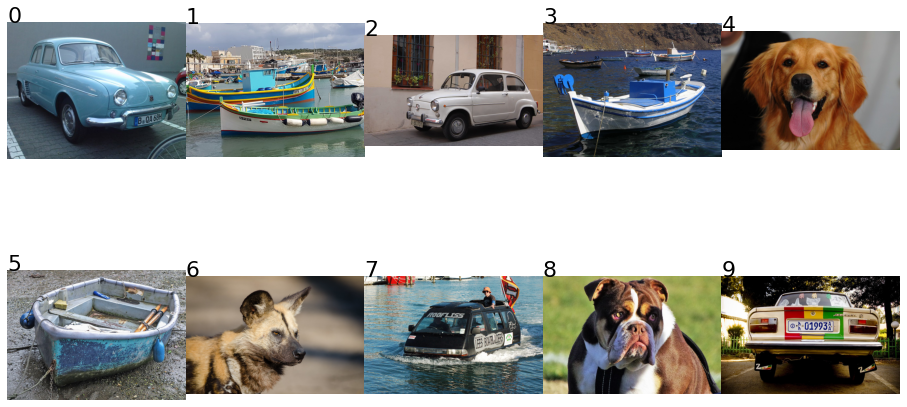

In [22]:
show_images([original_images[i] for i in population.current_best.chromosome])

In [23]:
score(population.current_best.chromosome), bigram_distances(population.current_best.chromosome)

(0.8021410471863217,
 array([0.78553204, 0.78267829, 0.74177223, 0.87040651, 0.84170645,
        0.81636624, 0.82439591, 0.78989939, 0.76651235]))

### GA for minimising mean distance between adjacent images (the opposite of the actual goal).

In [24]:
inverse_population = evol.Population(
    chromosomes=[random_individual() for _ in range(200)],
    eval_function=score,
    maximize=False).evaluate()

inverse_population = evolve_loop(inverse_population)

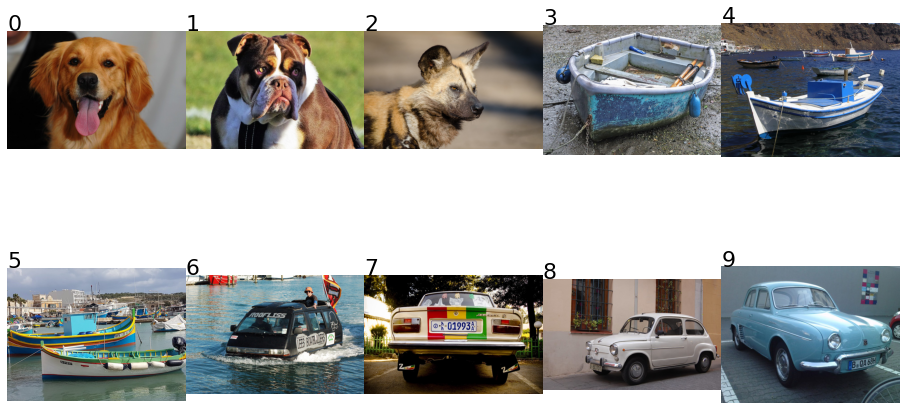

In [25]:
show_images([original_images[i] for i in inverse_population.current_best.chromosome])

In [26]:
score(inverse_population.current_best.chromosome), bigram_distances(inverse_population.current_best.chromosome)

(0.4739517420530319,
 array([0.55537289, 0.43990308, 0.81636624, 0.37466753, 0.35259706,
        0.51127693, 0.5462577 , 0.47024363, 0.19888061]))